In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy
import seaborn as sns

from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
ratings_path = os.path.join(os.getcwd(), os.path.join('ml-latest-small', 'ratings.csv'))
data = pd.read_csv(ratings_path, nrows=20000).drop(["timestamp"], axis=1)

## Train test split

In [3]:
def split_dataset(X, test_frac=0.1):
    test_set_size = int(X.shape[0]*test_frac)
    test_idx = np.random.choice(X.index, size=test_set_size, replace=False)
    test_set = X.loc[test_idx, :]
    train_set = X.copy()
    train_set.loc[test_idx, "rating"] = np.NaN
    return train_set, test_set

X_train, X_test = split_dataset(data)

In [4]:
util_matrix = X_train.pivot(index='userId', columns='movieId')
util_matrix.shape

(132, 4841)

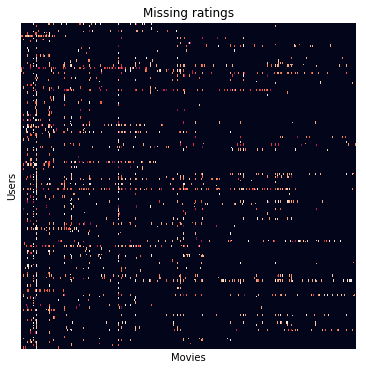

In [5]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))

cmap = sns.color_palette("YlGnBu", len(data["rating"].unique()))
sns.heatmap(util_matrix.fillna(-1), 
            yticklabels=False, 
            xticklabels=False, 
            #cmap=cmap,
            cbar=False, 
            ax=ax)

ax.set_title('Missing ratings')
ax.set_xlabel('Movies')
ax.set_ylabel('Users');

## Data imputation

In [6]:
def adjust_to_mean(df, util_matrix, col):
    group_means = df.groupby(col).aggregate(np.mean)
    util_copy = util_matrix.copy()
    for col in util_copy.columns:
        util_copy.loc[:, col] = group_means.values
    return util_copy

user_avg_ratings = adjust_to_mean(data.drop('movieId', axis=1), util_matrix, 'userId')
movie_avg_ratings = adjust_to_mean(data.drop('userId', axis=1), util_matrix.T, 'movieId').T
grand_mean = data.loc[:, "rating"].mean()

mean_adjusted_ratings = user_avg_ratings + movie_avg_ratings - grand_mean

In [7]:
util_matrix_filled = util_matrix.mask(np.isnan, other=mean_adjusted_ratings)

### Dummy classifier

In [8]:
mean_movie_rating = X_train["rating"].mean()
dummy_prediction = np.full(X_test["rating"].shape, mean_movie_rating)
dummy_rse = mean_squared_error(X_test["rating"], dummy_prediction)
dummy_rse**(1/2)

1.0144970626490037

### Mean adjusted classifier

In [9]:
def get_rse(prediction, test_set):
    ratings_comparison = prediction.merge(test_set, on=["userId", "movieId"]).loc[:, ["rating_x", "rating_y"]]
    error = mean_squared_error(ratings_comparison["rating_x"], 
                               ratings_comparison["rating_y"])
    return error ** (1/2)

In [10]:
mean_adj_rse = get_rse(util_matrix_filled.stack(), X_test)
mean_adj_rse

0.7554569327506876

### NMF

In [11]:
epsilon = 10e-4
nmf_offset = abs(np.min(util_matrix_filled.values)) + epsilon

In [12]:
nmf_model = NMF(init='random' , random_state=0)

rse_info = {}
# n_components <= min(132, 4841)
for n_components in range(2, 92, 10):
    nmf_model.n_components = n_components
    W = nmf_model.fit_transform(util_matrix_filled + nmf_offset)
    H = nmf_model.components_
    X_approx = np.dot(W,H) - nmf_offset
    X_approx = pd.DataFrame(X_approx, columns=util_matrix.columns, index=util_matrix.index)
    rse_info[n_components] = get_rse(X_approx.stack(), X_test)

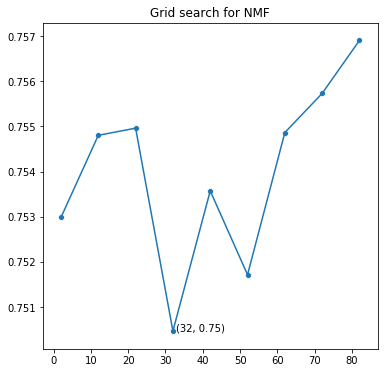

In [13]:
rse_series = pd.Series(rse_info)
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
sns.lineplot(data=pd.Series(rse_series), label="line", ax=ax)
sns.scatterplot(data=rse_series)

min_idx = rse_series.idxmin()
min_nmf = rse_series.min()
ax.text(min_idx+.7, min_nmf, str((min_idx, round(min_nmf, 3))))

ax.legend_.remove()
ax.set_title('Grid search for NMF')
ax;

## SVD

In [14]:
svd = TruncatedSVD(random_state=42)

svd_dict = {}
for n_components in range(1, 15, 2):
    svd.n_components = n_components
    svd.fit(util_matrix_filled)
    sigma = np.diag(svd.singular_values_)
    VT = svd.components_
    W = svd.transform(util_matrix_filled)/svd.singular_values_
    H = np.dot(sigma ,VT)
    svd_prediction = W @ H
    svd_prediction = pd.DataFrame(svd_prediction, 
                                  columns=util_matrix_filled.columns, 
                                  index=util_matrix_filled.index)
    svd_dict[n_components] = [get_rse(svd_prediction.stack(), X_test), 
                              svd.explained_variance_ratio_.sum()]

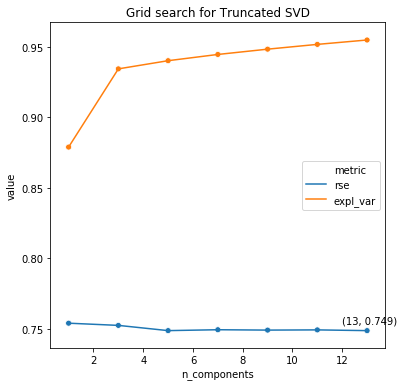

In [15]:
svd_df = pd.DataFrame.from_dict(svd_dict)
min_idx = svd_df.loc[0, :].idxmin()
min_svd = svd_df.loc[0, :].min()

svd_df["value"] = ["rse", "expl_var"]
svd_df.set_index("value", inplace=True)
svd_df = svd_df.T.stack().reset_index()
svd_df.columns = ["n_components", "metric", "value"]

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
sns.lineplot(x="n_components", y="value", hue="metric", data=svd_df, ax=ax)
sns.scatterplot(x="n_components", y="value", hue="metric", data=svd_df, ax=ax, legend=False)

ax.text(min_idx-1, min_svd+0.005, str((min_idx, round(min_svd, 3))))
ax.set_title('Grid search for Truncated SVD');

## Models comparison

In [16]:
comparison = {"Dummy": dummy_rse, 
              "Mean Adj": mean_adj_rse,  
              "NMF": min_nmf, 
              "SVD": min_svd}
pd.Series(comparison).round(5)

Dummy       1.02920
Mean Adj    0.75546
NMF         0.75047
SVD         0.74853
dtype: float64